# Project 1 – Decision Trees and Random Forests

In [1]:
# Reload all modules without having to restart the kernel
# Useful for development if you have edited any of the external code files.
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from decision_tree import DecisionTree
from random_forest import RandomForest
from sklearn.model_selection import KFold

## Dataset
Dataloading, preprocessing and visualisation


In [2]:
data = np.genfromtxt("letters.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[feature] for feature in feature_names]).T
y = data[target_name].astype(int)

print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Feature columns names: ['xbox', 'ybox', 'width', 'high', 'onpix', 'xbar', 'ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'xege', 'xegvy', 'yege', 'yegvx']
Target column name: label
X shape: (2000, 16)
y shape: (2000,)


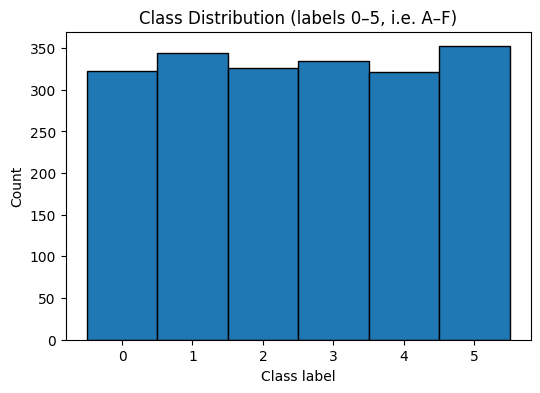

In [3]:
plt.figure(figsize=(6,4))
plt.hist(y, bins=np.arange(y.min(), y.max()+2)-0.5, edgecolor="black")
plt.title("Class Distribution (labels 0–5, i.e. A–F)")
plt.xlabel("Class label")
plt.ylabel("Count")
plt.xticks(range(y.min(), y.max()+1))
plt.show()

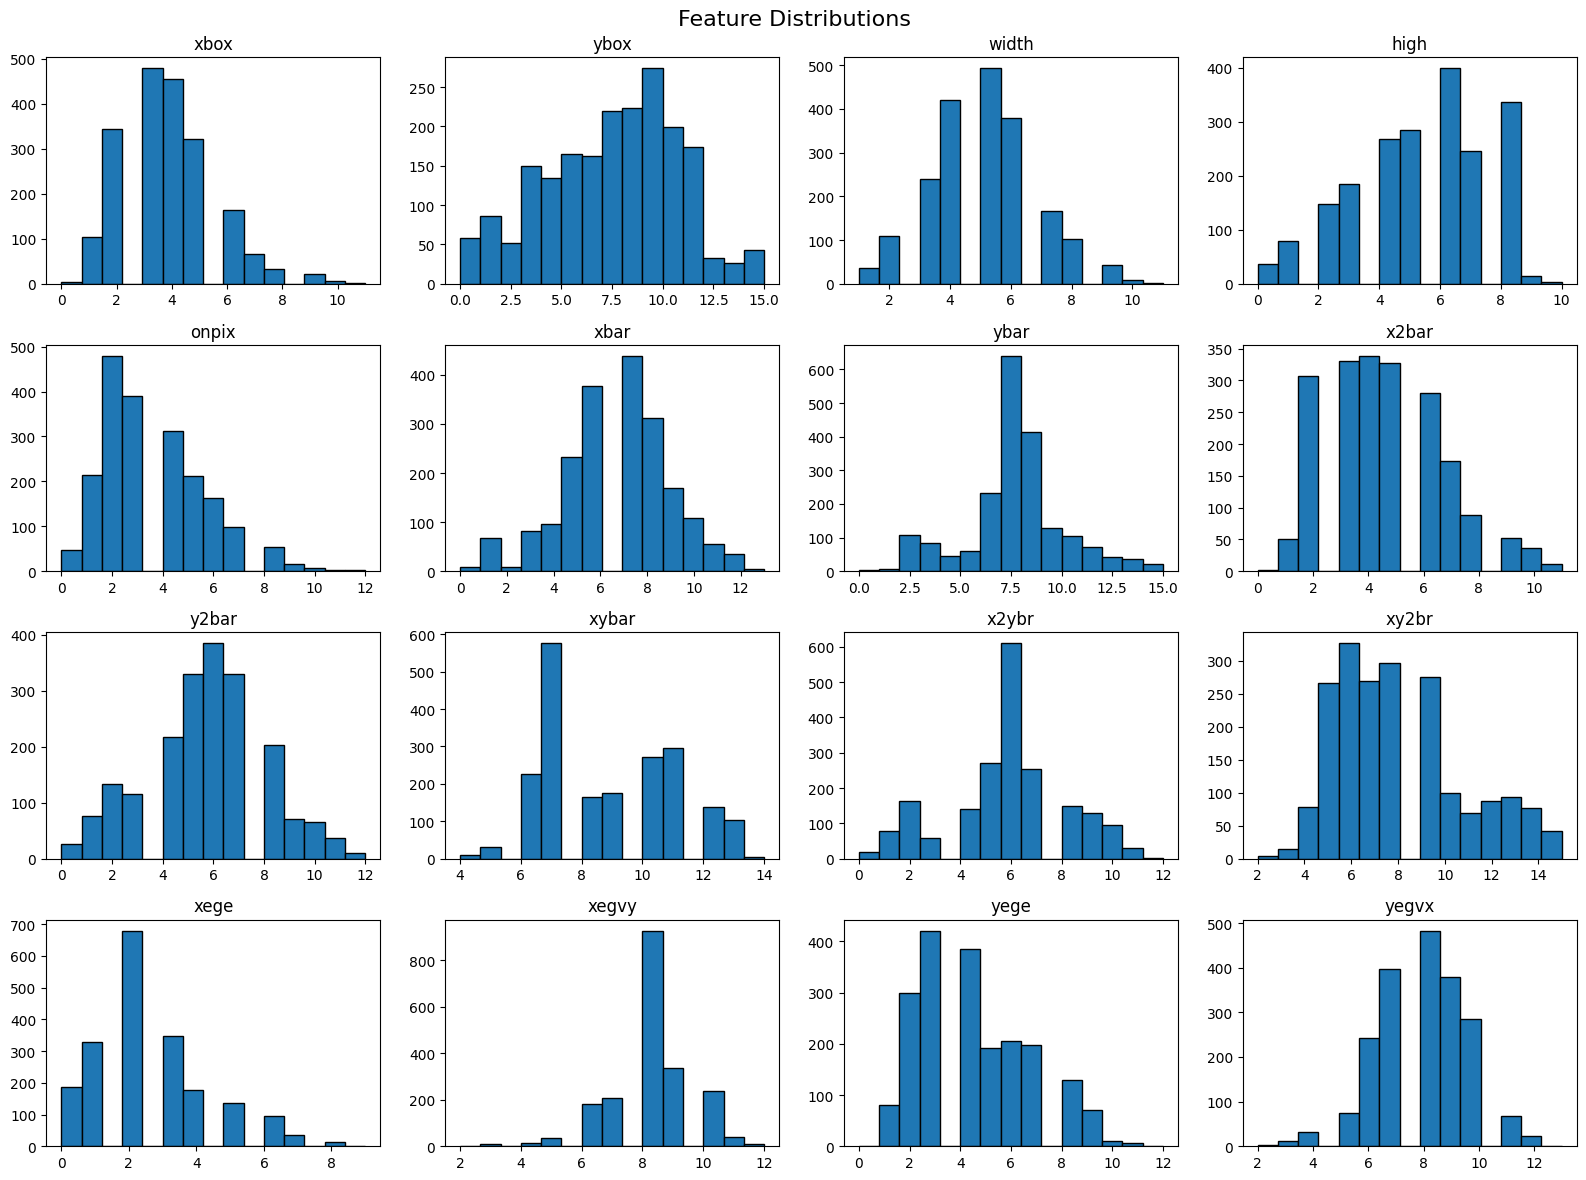

In [4]:
fig, axes = plt.subplots(4, 4, figsize=(16,12))
axes = axes.flatten()

for i in range(len(feature_names)):
    axes[i].hist(X[:, i], bins=15, edgecolor="black")
    axes[i].set_title(feature_names[i])
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

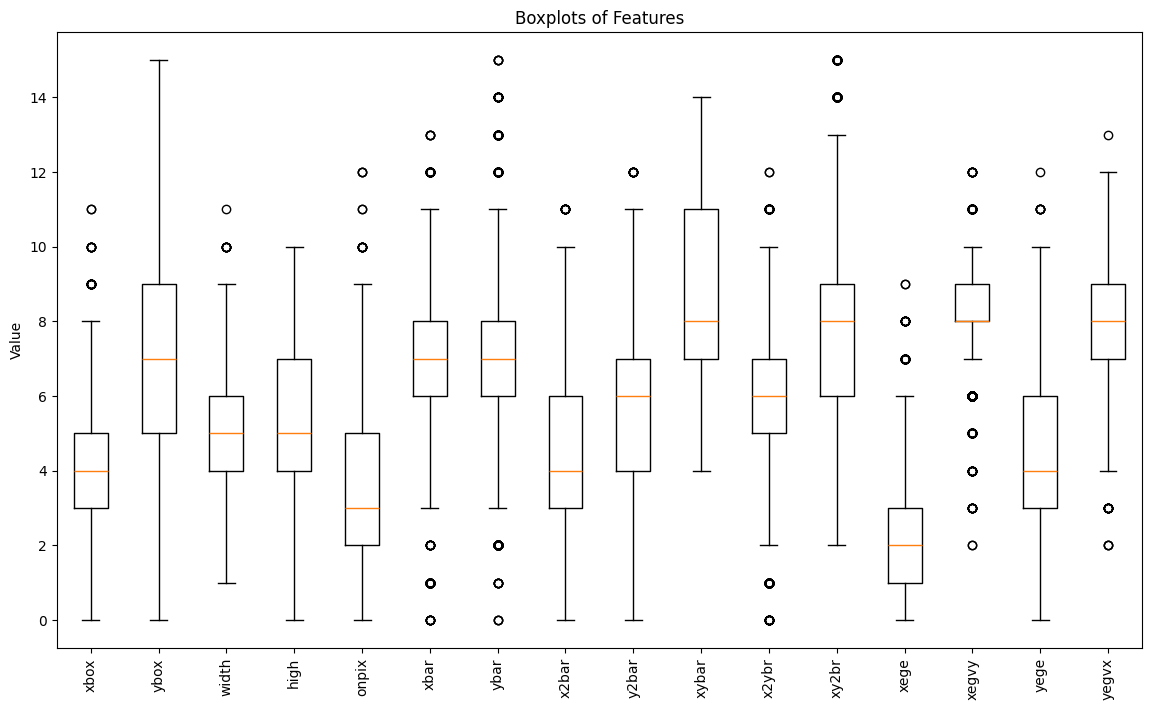

In [6]:
plt.figure(figsize=(14,8))
plt.boxplot(X, tick_labels=feature_names)
plt.xticks(rotation=90)
plt.title("Boxplots of Features")
plt.ylabel("Value")
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

## Hyperparameter tuning

In [4]:
def kfold_search(model_class, X, y, param_grid, k):
    """
    Runs k-fold cross validation for a given model class and parameter grid.

    Parameters:
    model_class: DecisionTree or RandomForest
    X, y: dataset
    param_grid: list of hyperparameters
    k: number of folds

    Returns:
    best_params, best_score
    """
    best_score, best_params = 0, None
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for params in param_grid:
        scores = []

        for train_index, val_index in kf.split(X):
            X_train_k, X_val = X[train_index], X[val_index]
            y_train_k, y_val = y[train_index], y[val_index]

            model = model_class(**params)
            model.fit(X_train_k, y_train_k)
            y_pred = model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            scores.append(acc)
            

        mean_acc, std = np.mean(scores), np.std(scores)
    
        print(f"{model_class.__name__}, params={params}, acc={mean_acc:.3f}, std={std:.3f}")
        
        score = mean_acc - std
        if score > best_score:
            best_score, best_params = score, params

    return best_params, best_score

In [5]:
depth = [5, 10, 15, 20,  None]
criteria = ["entropy", "gini"]
n_estimators_values = [10, 20, 50, 100]
max_features_values = ["sqrt", "log2", None]

dt_param_grid = [{"max_depth": d, "criterion": c} for d in depth for c in criteria]
rf_param_grid = [
    {"max_depth": d, "criterion": c, "n_estimators": n, "max_features": mf}
    for d in depth
    for c in criteria
    for n in n_estimators_values
    for mf in max_features_values
]

best_dt_params, best_dt_score = kfold_search(DecisionTree, X_train, y_train, dt_param_grid, 5)
print(f"\nBest DecisionTree params: {best_dt_params}, acc={best_dt_score:.3f}")

best_rf_params, best_rf_score = kfold_search(RandomForest, X_train, y_train, rf_param_grid, 5)
print(f"\nBest RandomForest params: {best_rf_params}, acc={best_rf_score:.3f}")


DecisionTree, params={'max_depth': 5, 'criterion': 'entropy'}, acc=0.804, std=0.019
DecisionTree, params={'max_depth': 5, 'criterion': 'gini'}, acc=0.817, std=0.012
DecisionTree, params={'max_depth': 10, 'criterion': 'entropy'}, acc=0.892, std=0.023
DecisionTree, params={'max_depth': 10, 'criterion': 'gini'}, acc=0.890, std=0.014
DecisionTree, params={'max_depth': 15, 'criterion': 'entropy'}, acc=0.892, std=0.018
DecisionTree, params={'max_depth': 15, 'criterion': 'gini'}, acc=0.884, std=0.012
DecisionTree, params={'max_depth': 20, 'criterion': 'entropy'}, acc=0.884, std=0.018
DecisionTree, params={'max_depth': 20, 'criterion': 'gini'}, acc=0.884, std=0.015
DecisionTree, params={'max_depth': None, 'criterion': 'entropy'}, acc=0.887, std=0.015
DecisionTree, params={'max_depth': None, 'criterion': 'gini'}, acc=0.890, std=0.022

Best DecisionTree params: {'max_depth': 10, 'criterion': 'gini'}, acc=0.876
RandomForest, params={'max_depth': 5, 'criterion': 'entropy', 'n_estimators': 10, 'max

## Evaluation

In [6]:
final_dt = DecisionTree(**best_dt_params).fit(X_train, y_train)
final_rf = RandomForest(**best_rf_params).fit(X_train, y_train)
dt_test_acc = accuracy_score(y_test, final_dt.predict(X_test))
rf_test_acc = accuracy_score(y_test, final_rf.predict(X_test))

print("\n--- Final Test Results ---")
print(f"DecisionTree Test Accuracy: {dt_test_acc:.3f}")
print(f"RandomForest Test Accuracy: {rf_test_acc:.3f}")


--- Final Test Results ---
DecisionTree Test Accuracy: 0.885
RandomForest Test Accuracy: 0.963


In [15]:
best_dt_params_sk, best_dt_score_sk = kfold_search(DecisionTreeClassifier, X_train, y_train, dt_param_grid, k=5)
print(f"\nBest DecisionTree params: {best_dt_params_sk}, acc={best_dt_score_sk:.3f}")
best_rf_params_sk, best_rf_score_sk = kfold_search(RandomForestClassifier, X_train, y_train, rf_param_grid, k=5)
print(f"\nBest RandomForest params: {best_rf_params_sk}, acc={best_rf_score_sk:.3f}")

dt_sk = DecisionTreeClassifier(**best_dt_params_sk, random_state=42).fit(X_train, y_train)
rf_sk = RandomForestClassifier(**best_rf_params_sk, random_state=42).fit(X_train, y_train)

acc_dt_sk = accuracy_score(y_test, dt_sk.predict(X_test))
acc_rf_sk = accuracy_score(y_test, rf_sk.predict(X_test))
print(f"Sklearn DecisionTree: {acc_dt_sk:.3f}")
print(f"Sklearn RandomForest: {acc_rf_sk:.3f}")

DecisionTreeClassifier, params={'max_depth': 5, 'criterion': 'entropy'}, acc=0.831, std=0.024
DecisionTreeClassifier, params={'max_depth': 5, 'criterion': 'gini'}, acc=0.816, std=0.013
DecisionTreeClassifier, params={'max_depth': 10, 'criterion': 'entropy'}, acc=0.927, std=0.012
DecisionTreeClassifier, params={'max_depth': 10, 'criterion': 'gini'}, acc=0.914, std=0.008
DecisionTreeClassifier, params={'max_depth': 15, 'criterion': 'entropy'}, acc=0.925, std=0.007
DecisionTreeClassifier, params={'max_depth': 15, 'criterion': 'gini'}, acc=0.922, std=0.011
DecisionTreeClassifier, params={'max_depth': 20, 'criterion': 'entropy'}, acc=0.925, std=0.009
DecisionTreeClassifier, params={'max_depth': 20, 'criterion': 'gini'}, acc=0.925, std=0.008
DecisionTreeClassifier, params={'max_depth': None, 'criterion': 'entropy'}, acc=0.927, std=0.011
DecisionTreeClassifier, params={'max_depth': None, 'criterion': 'gini'}, acc=0.922, std=0.007

Best DecisionTree params: {'max_depth': 15, 'criterion': 'entr

In [21]:
dt_sk = DecisionTreeClassifier(**best_dt_params, random_state=42).fit(X_train, y_train)
rf_sk = RandomForestClassifier(**best_rf_params, random_state=42).fit(X_train, y_train)
acc_dt_sk2 = accuracy_score(y_test, dt_sk.predict(X_test))
acc_rf_sk2 = accuracy_score(y_test, rf_sk.predict(X_test))
print(f"Sklearn DecisionTree with best params from my models: {acc_dt_sk:.3f}")
print(f"Sklearn RandomForest with best params from my models:: {acc_rf_sk:.3f}")

Sklearn DecisionTree with best params from my models: 0.917
Sklearn RandomForest with best params from my models:: 0.968


## Permutation

In [11]:
def permutation_importance(model, X, y, metric, n_repeats=30, seed=42):
    """
    Calculates permutation feature importance by shuffling each feature 
    and measuring the drop in model performance
    
    Parameters:
    model : trained model with predict()
    X, y : dataset
    metric : scoring function
    n_repeats : number of permutations per feature
    seed : random seed    
    
    Returns:
    np.ndarray : importance scores for each feature
    """
    rng = np.random.default_rng(seed)

    baseline_score = metric(y, model.predict(X))

    n_features = X.shape[1]
    importances = np.zeros(n_features)

    for j in range(n_features):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            rng.shuffle(X_permuted[:, j])
            score = metric(y, model.predict(X_permuted))
            scores.append(score)
        importances[j] = baseline_score - np.mean(scores)

    return importances

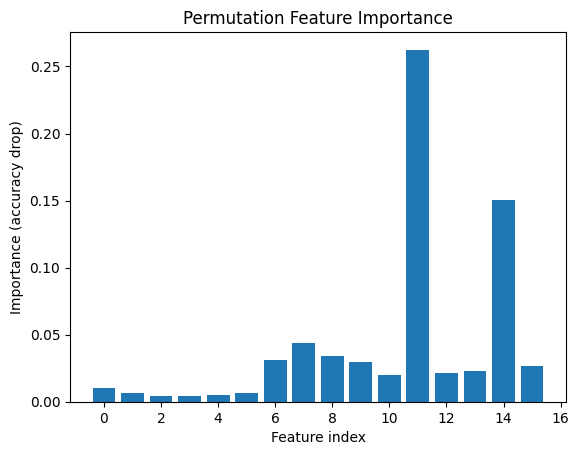

In [14]:
importance = permutation_importance(final_rf, X_test, y_test, accuracy_score, n_repeats=30)
plt.bar(range(len(importance)), importance)
plt.xlabel("Feature index")
plt.ylabel("Importance (accuracy drop)")
plt.title("Permutation Feature Importance")
plt.show()